<a href="https://colab.research.google.com/github/tomreitz/cs766-computer-vision-project/blob/main/code/OpenCV_dlib_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is a proof-of-concept for using OpenCV and dlib to detect faces in images find facial landmarks (corners of eyes and mouth, nose/nostrils, eyebrows, etc.).

Code is based on these sources:
*   https://github.com/nlhkh/face-alignment-dlib
*   https://www.superdatascience.com/blogs/opencv-face-detection
*   https://pysource.com/2019/03/12/face-landmarks-detection-opencv-with-python/

The workhorse here is dlib, a cool C++ / Python library that uses an ensemble of regression trees to locate 68 predefined facial landmarks. Further info available at
* [dlib website](http://dlib.net/)
* [2014 paper "One Millisecond Face Alignment with an Ensemble of Regression Trees" by Kazemi et al.](https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Kazemi_One_Millisecond_Face_2014_CVPR_paper.pdf)
* [Pre-trained models for dlib](https://github.com/davisking/dlib-models/) (we're using shape_predictor_68_face_landmarks.dat here)

In [1]:
#import OpenCV library
import cv2
#import dlib facial landmark detection library
import dlib
#import NumPy for processing facial landmarks
import numpy as np
#import matplotlib library
import matplotlib.pyplot as plt
%matplotlib inline

def convertToRGB(img): 
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# uncomment the lines below to download/extract the necessary files on first run
#!wget https://tomreitz.github.io/cs766-computer-vision-project/data/pexels-photo-638196.jpeg
#!wget https://upload.wikimedia.org/wikipedia/commons/a/a3/Elderly_Gambian_woman_face_portrait.jpg
#!wget https://upload.wikimedia.org/wikipedia/commons/1/1f/Gardengnome_face.jpg
#!wget https://upload.wikimedia.org/wikipedia/commons/1/1c/Ami_Bera_wearing_face_mask_-_May_15_2020.jpg
#!wget https://upload.wikimedia.org/wikipedia/commons/8/81/Michael_Shapiro_NYTF.jpg
#!wget https://github.com/davisking/dlib-models/raw/master/shape_predictor_68_face_landmarks.dat.bz2
#!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt2.xml
#!wget https://github.com/kurnianggoro/GSOC2017/raw/master/data/lbfmodel.yaml
#!bunzip2 shape_predictor_68_face_landmarks.dat.bz2

--2021-03-10 14:20:30--  https://tomreitz.github.io/cs766-computer-vision-project/data/pexels-photo-638196.jpeg
Resolving tomreitz.github.io (tomreitz.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to tomreitz.github.io (tomreitz.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 638893 (624K) [image/jpeg]
Saving to: ‘pexels-photo-638196.jpeg’

pexels-photo-638196 100%[===================>] 623.92K  --.-KB/s    in 0.04s   

2021-03-10 14:20:30 (15.1 MB/s) - ‘pexels-photo-638196.jpeg’ saved [638893/638893]

--2021-03-10 14:20:30--  https://upload.wikimedia.org/wikipedia/commons/a/a3/Elderly_Gambian_woman_face_portrait.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5111043 (4.9M) [image/jpeg]
Saving to: ‘Elderly_G

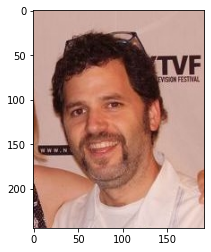

In [ ]:
# load an image for testing
#img = cv2.imread('pexels-photo-638196.jpeg')
#img = cv2.imread('Elderly_Gambian_woman_face_portrait.jpg')
#img = cv2.imread('Gardengnome_face.jpg')
#img = cv2.imread('Ami_Bera_wearing_face_mask_-_May_15_2020.jpg')
img = cv2.imread('Michael_Shapiro_NYTF.jpg')
# show the image
plt.imshow(convertToRGB(img))

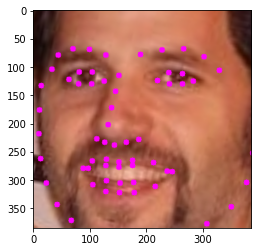

In [ ]:
# code borrowed from https://github.com/nlhkh/face-alignment-dlib
LEFT_EYE_INDICES = [36, 37, 38, 39, 40, 41]
RIGHT_EYE_INDICES = [42, 43, 44, 45, 46, 47]

def rect_to_tuple(rect):
    left = rect.left()
    right = rect.right()
    top = rect.top()
    bottom = rect.bottom()
    return left, top, right, bottom

def extract_eye(shape, eye_indices):
    points = map(lambda i: shape.part(i), eye_indices)
    return list(points)

def extract_eye_center(shape, eye_indices):
    points = extract_eye(shape, eye_indices)
    xs = map(lambda p: p.x, points)
    ys = map(lambda p: p.y, points)
    return sum(xs) // 6, sum(ys) // 6

def extract_left_eye_center(shape):
    return extract_eye_center(shape, LEFT_EYE_INDICES)

def extract_right_eye_center(shape):
    return extract_eye_center(shape, RIGHT_EYE_INDICES)

def angle_between_2_points(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    tan = (y2 - y1) / (x2 - x1)
    return np.degrees(np.arctan(tan))

def get_rotation_matrix(p1, p2):
    angle = angle_between_2_points(p1, p2)
    x1, y1 = p1
    x2, y2 = p2
    xc = (x1 + x2) // 2
    yc = (y1 + y2) // 2
    M = cv2.getRotationMatrix2D((xc, yc), angle, 1)
    return M

def crop_image(image, det):
    left, top, right, bottom = rect_to_tuple(det)
    return image[top:bottom, left:right]

# detect faces in the image:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
#img = cv2.imread('pexels-photo-638196.jpeg')
img = cv2.imread('Elderly_Gambian_woman_face_portrait.jpg')
#img = cv2.imread('Gardengnome_face.jpg')
#img = cv2.imread('Ami_Bera_wearing_face_mask_-_May_15_2020.jpg')
img = cv2.imread('Michael_Shapiro_NYTF.jpg')
height, width = img.shape[:2]
# scale every image to max 800 pixels in either dimension
if height>width: scale = 1000/height
else: scale = 1000/width
s_height, s_width = round(height*scale), round(width*scale)
img = cv2.resize(img, (s_width, s_height))
#plt.imshow(convertToRGB(img))
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# extract landmarks and align face
dets = detector(gray_img, 1)
if len(dets)==0:
    print("no face found :(")
else:
    shape = predictor(gray_img, dets[0])
    left_eye = extract_left_eye_center(shape)
    right_eye = extract_right_eye_center(shape)
    M = get_rotation_matrix(left_eye, right_eye)
    rotated = cv2.warpAffine(img, M, (s_width, s_height), flags=cv2.INTER_CUBIC)
    cropped = crop_image(rotated, dets[0])

    # re-extract landmarks in aligned face and annottate them
    dets = detector(cropped, 1)
    if len(dets)==0:
        print("no face found :(")
    else:
        shape = predictor(cropped, dets[0])
        for n in range(0, 68):
            x = shape.part(n).x
            y = shape.part(n).y
            cv2.circle(cropped, (x, y), 5, (255, 0, 255), -1)

        # show the face with landmarks
        plt.imshow(convertToRGB(cropped))

Here's an alternate way to do it that uses Haar classifiers (and doesn't rotate/align the face). Seems to work about as well as the dlib method above.

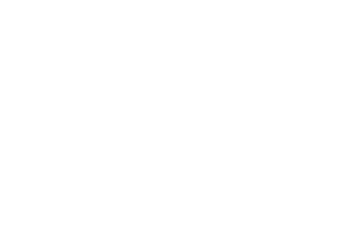

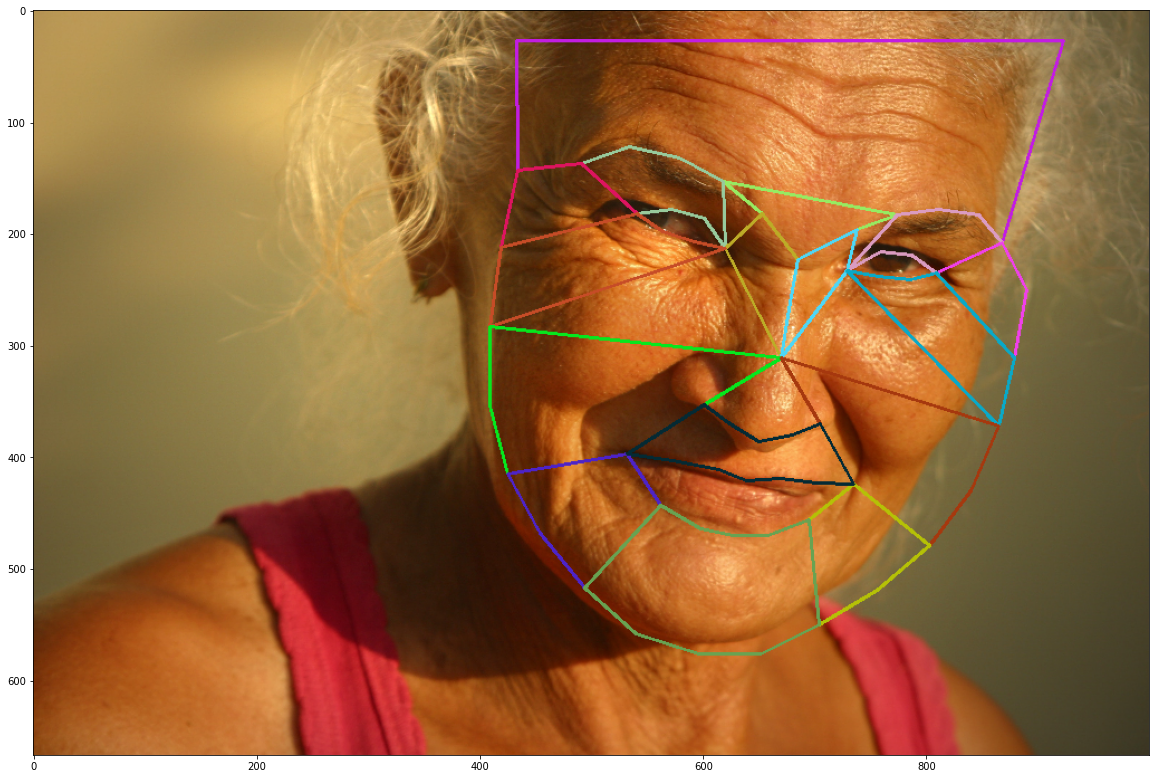

In [64]:
# code borrowed from https://medium.com/analytics-vidhya/facial-landmarks-and-face-detection-in-python-with-opencv-73979391f30e
haarcascade = "haarcascade_frontalface_alt2.xml"
detector = cv2.CascadeClassifier(haarcascade)

img = cv2.imread('pexels-photo-638196.jpeg')
#img = cv2.imread('Elderly_Gambian_woman_face_portrait.jpg')
#img = cv2.imread('Gardengnome_face.jpg')
#img = cv2.imread('Ami_Bera_wearing_face_mask_-_May_15_2020.jpg')
#img = cv2.imread('Michael_Shapiro_NYTF.jpg')
height, width = img.shape[:2]
# scale every image to max 800 pixels in either dimension
if height>width: scale = 1000/height
else: scale = 1000/width
s_height, s_width = round(height*scale), round(width*scale)
img = cv2.resize(img, (s_width, s_height))
#plt.imshow(convertToRGB(img))
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = detector.detectMultiScale(gray_img)
for face in faces:
#     save the coordinates in x, y, w, d variables
    (x,y,w,d) = face
    # Draw a white coloured rectangle around each face using the face's coordinates
    # on the "image_template" with the thickness of 2 
    #cv2.rectangle(img,(x,y),(x+w, y+d),(255, 255, 255), 2)

if len(faces)>0:
    LBFmodel = "lbfmodel.yaml"
    landmark_detector  = cv2.face.createFacemarkLBF()
    landmark_detector.loadModel(LBFmodel)

    _, landmarks = landmark_detector.fit(gray_img, faces)
    for landmark in landmarks:
        i = 1
        for x,y in landmark[0]:
            #cv2.circle(img, (x, y), 6, (0, 255, 0), -1)
            #cv2.putText(img,str(i), (x,y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255))
            i += 1
    rhytide_polygon_index = {
        'forehead': [1, 18, 19, 20, 21, 24, 25, 26, 27],
        'frown': [21, 22, 28, 23, 24],
        'upper_eye_hood_left': [18, 19, 20, 21, 40, 39, 38, 37],
        'upper_eye_hood_right': [24, 25, 26, 27, 46, 45, 44, 43],
        'crows_feet_left': [1, 2, 37, 18],
        'crows_feet_right': [17, 16, 46, 27],
        'bunny_lines_left': [22, 28, 29, 30, 40], # include 30?
        'bunny_lines_right': [23, 28, 29, 30, 43], # include 30?
        'bags_left': [2, 3, 40, 41, 42, 37], # remove 29?
        'bags_right': [16, 15, 43, 48, 47, 46], # remove 29?
        'laugh_lines_left': [3, 4, 5, 49, 32, 30],
        'laugh_lines_right': [15, 14, 13, 55, 36, 30],
        'jowls_left': [5, 6, 7, 60, 49],
        'jowls_right': [13, 12, 11, 56, 55],
        'lip_lines': [36, 35, 34, 33, 32, 49, 50, 51, 52, 53, 54, 55],
        'mental_crease': [7, 8, 9, 10, 11, 56, 57, 58, 59, 60]
    }
    for key in rhytide_polygon_index:
        polygon = np.array(landmarks[0][0][[x-1 for x in rhytide_polygon_index[key]]])
        if key=='forehead':
            (x,y,w,d) = faces[0]
            polygon = np.append(polygon, [[x+w,y], [x,y]], axis=0)
        color = tuple([int(x) for x in list(np.random.choice(range(256), size=3))])
        cv2.polylines(img, np.int32([polygon]), True, color, 2)
    plt.axis("off")
    plt.figure(figsize = (20,15))
    plt.imshow(convertToRGB(img))
else:
    print('No faces found :(')


Next steps are to segment face into areas for each rhytide type based on landmarks, then do edge detection in each area to quantify wrinkles.

The 68-landmark model produces x-y coordinates for 68 points on a face. Specific points have repeatable indexes, i.e., point #3 is the outside corner of the left eye, point #46 is the outside corner of the right eye, etc. So we can construct polygons from several of these points to designate areas to analyze for different rhytide types. Specifically:

1. **Forehead lines** would be found in the polygon composed of points 1, 18, 19, 20, 21, 24, 25, 26, 27, and the top of the face bounding box.
1. **Glabellar frown lines** would be found in the polygon composed of the points 21, 22, 28, 23, 24.
1. **Upper eyelid hooding** would be found in the polygon composed of the points 18, 19, 20, 21, 40, 39, 38, 37 (for the left eye) and 24, 25, 26, 27, 46, 45, 44, 43 (for the right eye).
1. **Crow's feet (outside corners of eyes)** would be found in the polygon composed of the points 1, 2, 37, 18 (for the left eye) and 17, 16, 46, 27 (for the right eye).
1. **Bunny lines (inside corners of eyes)** would be found in the polygon composed of the points 22, 28, 29, 40 (for the left eye) and 23, 28, 29, 43 (for the right eye).
1. **Bagging of lower lids** would be found in the polygon composed of the points 2, 3, 29, 40, 41, 42, 37 (for the left eye) and 16, 15, 29, 43, 44, 45, 46 (for the right eye).
1. **Nasolabial folds (laugh lines)** would be found in the polygon composed of the points 3, 4, 5, 49, 32, 30 (for the left side) and 15, 14, 13, 55, 36, 30 (for the right side).
1. **Marionette lines or jowls** would be found in the polygon composed of the points 5, 6, 7, 49 (for the left side) and 13, 12, 11, 55 (for the right side).
1. **Lip lines (vertical lines on upper and/or lower lip)** would be found in the polygon composed of the points 32, 33, 34, 35, 36, 49, 50, 51, 52, 53, 54, 55.
1. **Mental crease (between chin and lower lip)** would be found in the polygon composed of the points 7, 8, 9, 10, 11, 56, 57, 58, 59, 60.

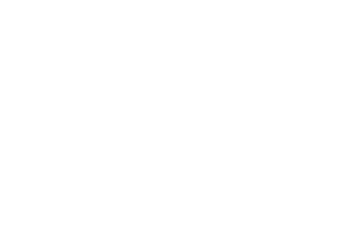

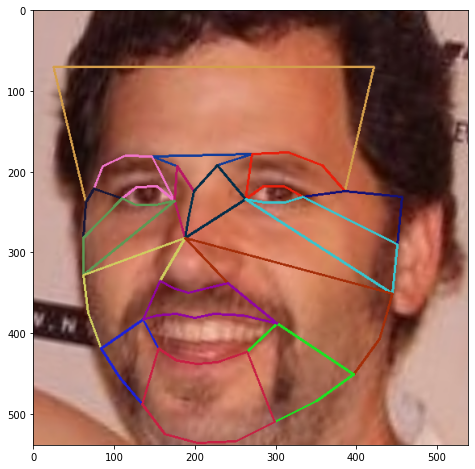

In [148]:
# code borrowed from https://github.com/nlhkh/face-alignment-dlib
LEFT_EYE_INDICES = [36, 37, 38, 39, 40, 41]
RIGHT_EYE_INDICES = [42, 43, 44, 45, 46, 47]

def rect_to_tuple(rect):
    left = rect.left()
    right = rect.right()
    top = rect.top()
    bottom = rect.bottom()
    return left, top, right, bottom

def extract_eye(shape, eye_indices):
    points = shape[[x for x in eye_indices]]
    return list(points)

def extract_eye_center(shape, eye_indices):
    points = extract_eye(shape, eye_indices)
    xs = map(lambda p: p[0], points)
    ys = map(lambda p: p[1], points)
    return sum(xs) // 6, sum(ys) // 6

def extract_left_eye_center(shape):
    return extract_eye_center(shape, LEFT_EYE_INDICES)

def extract_right_eye_center(shape):
    return extract_eye_center(shape, RIGHT_EYE_INDICES)

def angle_between_2_points(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    tan = (y2 - y1) / (x2 - x1)
    return np.degrees(np.arctan(tan))

def get_rotation_matrix(p1, p2):
    angle = angle_between_2_points(p1, p2)
    x1, y1 = p1
    x2, y2 = p2
    xc = (x1 + x2) // 2
    yc = (y1 + y2) // 2
    M = cv2.getRotationMatrix2D((xc, yc), angle, 1)
    return M

def crop_image(image, det):
    #left, top, right, bottom = rect_to_tuple(det)
    height, width = image.shape[:2]
    (x,y,w,d) = det
    wpadding = 0.1*w
    dpadding = 0.1*d
    top = max(0, round(y-dpadding))
    bottom = min(height, round(y+d+dpadding))
    left = max(0, round(x-wpadding))
    right = min(width, round(x+w+wpadding))
    return image[top:bottom, left:right]

# code borrowed from https://medium.com/analytics-vidhya/facial-landmarks-and-face-detection-in-python-with-opencv-73979391f30e
haarcascade = "haarcascade_frontalface_alt2.xml"
detector = cv2.CascadeClassifier(haarcascade)

#img = cv2.imread('pexels-photo-638196.jpeg')
#img = cv2.imread('Elderly_Gambian_woman_face_portrait.jpg')
#img = cv2.imread('Gardengnome_face.jpg')
#img = cv2.imread('Ami_Bera_wearing_face_mask_-_May_15_2020.jpg')
img = cv2.imread('Michael_Shapiro_NYTF.jpg')
height, width = img.shape[:2]
# scale every image to max 1000 pixels in either dimension
if height>width: scale = 1000/height
else: scale = 1000/width
s_height, s_width = round(height*scale), round(width*scale)
img = cv2.resize(img, (s_width, s_height))
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = detector.detectMultiScale(gray_img)
if len(faces)>0:
    #(fx, fy, fw, fd) = faces[0]
    LBFmodel = "lbfmodel.yaml"
    landmark_detector  = cv2.face.createFacemarkLBF()
    landmark_detector.loadModel(LBFmodel)
    shape = landmarks[0][0]
    #_, landmarks = landmark_detector.fit(gray_img, faces)
    #for landmark in landmarks:
    #    for x,y in landmark[0]:
    #        cv2.circle(img, (x, y), 6, (0, 255, 0), -1)
    
    #plt.imshow(convertToRGB(img))
    left_eye = extract_left_eye_center(shape)
    right_eye = extract_right_eye_center(shape)
    M = get_rotation_matrix(left_eye, right_eye)
    rotated = cv2.warpAffine(img, M, (s_width, s_height), flags=cv2.INTER_CUBIC)
    cropped = crop_image(rotated, faces[0])
    
    # re-extract landmarks in aligned face and annotate them
    gray_img = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
    faces = detector.detectMultiScale(gray_img)
    if len(faces)>0:
        LBFmodel = "lbfmodel.yaml"
        landmark_detector  = cv2.face.createFacemarkLBF()
        landmark_detector.loadModel(LBFmodel)

        _, landmarks = landmark_detector.fit(gray_img, faces)
        #for landmark in landmarks:
        #    for x,y in landmark[0]:
        #        #cv2.circle(cropped, (x, y), 6, (0, 255, 0), -1)
        rhytide_polygon_index = {
            'forehead': [1, 18, 19, 20, 21, 24, 25, 26, 27],
            'frown': [21, 22, 28, 23, 24],
            'upper_eye_hood_left': [18, 19, 20, 21, 40, 39, 38, 37],
            'upper_eye_hood_right': [24, 25, 26, 27, 46, 45, 44, 43],
            'crows_feet_left': [1, 2, 37, 18],
            'crows_feet_right': [17, 16, 46, 27],
            'bunny_lines_left': [22, 28, 29, 30, 40], # include 30?
            'bunny_lines_right': [23, 28, 29, 30, 43], # include 30?
            'bags_left': [2, 3, 40, 41, 42, 37], # remove 29?
            'bags_right': [16, 15, 43, 48, 47, 46], # remove 29?
            'laugh_lines_left': [3, 4, 5, 49, 32, 30],
            'laugh_lines_right': [15, 14, 13, 55, 36, 30],
            'jowls_left': [5, 6, 7, 60, 49],
            'jowls_right': [13, 12, 11, 56, 55],
            'lip_lines': [36, 35, 34, 33, 32, 49, 50, 51, 52, 53, 54, 55],
            'mental_crease': [7, 8, 9, 10, 11, 56, 57, 58, 59, 60]
        }
        for key in rhytide_polygon_index:
            polygon = np.array(landmarks[0][0][[x-1 for x in rhytide_polygon_index[key]]])
            if key=='forehead':
                (x,y,w,d) = faces[0]
                polygon = np.append(polygon, [[x+w,y], [x,y]], axis=0)
            color = tuple([int(x) for x in list(np.random.choice(range(256), size=3))])
            cv2.polylines(cropped, np.int32([polygon]), True, color, 2)
        plt.axis("off")
        plt.figure(figsize = (8,8))
        plt.imshow(convertToRGB(cropped))
    else:
        print('No faces found :(')
else:
    print('No faces found :(')